## Load useful libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

import warnings

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima import auto_arima

## Define user settings for CLI-based call to run this notebook

I believe these are meant to be set to default values here, which can be overridden as part of the CLI-based call to run this notebook.

Note that we have annotated this cell with a tag called "parameters" in the Jupyter interface (I believe that the comment "#parameters" in the code below is not the tag, just documentation):

In [2]:
#parameters
filename_parquet = 'resampled.parquet'

In [3]:
# Parameters
filename_parquet = "resampled.parquet"


## Hard-coded user settings

Crude:

In [4]:
p_value_cutoff_adfuller = 0.05
alpha_acf_and_pacf = 0.05
proportion_of_timestamps_to_train_model_with = 0.9
time_series_frequency = 'D'

## Load the time-series data we are working with

We assume that the current date's pre-resampled source values have not fully come in yet, so we also cut today's values from our time series.

Note that we do not fuss about timezones here for this example, though in a production situation we should:

In [5]:
today = datetime.datetime.now().date()

df = pd.read_parquet(filename_parquet)
df['date'] = [x.to_pydatetime().date() for x in df.index]
df = df[df['date'] != today].copy()
df.drop(columns = ['date'], inplace=True)

In [6]:
df

,spot_price
timestamp,
2024-10-05 00:00:00+00:00,0.07000
2024-10-06 00:00:00+00:00,0.06975
2024-10-07 00:00:00+00:00,0.06950
2024-10-08 00:00:00+00:00,0.06975
2024-10-09 00:00:00+00:00,0.06930
...,...
2025-01-02 00:00:00+00:00,0.07580
2025-01-03 00:00:00+00:00,0.07666
2025-01-04 00:00:00+00:00,0.07760


## Divide into training and testing sets

In [7]:
n_train = np.int32(np.round(proportion_of_timestamps_to_train_model_with * len(df.index)))
n_test = np.int32(np.round((1. - proportion_of_timestamps_to_train_model_with) * len(df.index)))

df_train = df.iloc[0:n_train, :]
df_test = df.iloc[n_train:, :]

# QA
print(len(df_train.index) + len(df_test.index))
print(len(df.index))
print(len(df_train.index), len(df_test.index))

94
94
85 9


## Plot the full time series

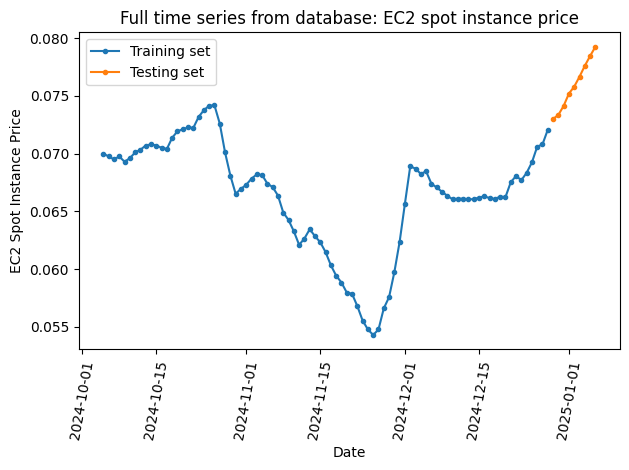

In [8]:
plt.figure()
plt.plot(df_train.index, df_train['spot_price'], '.-', label = 'Training set')
plt.plot(df_test.index, df_test['spot_price'], '.-', label = 'Testing set')
plt.xticks(rotation = 80)
plt.xlabel('Date')
plt.ylabel('EC2 Spot Instance Price')
plt.title('Full time series from database: EC2 spot instance price')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

## Run an Augmented Dickey–Fuller test

From Wikipedia (paraphrased):

"The augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis depends on which version of the test is used, but is usually stationarity or trend-stationarity. It is an augmented version of the Dickey–Fuller test for a larger and more complicated set of time series models" [https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test]

From AI-based Google output from a search on the terms "python statsmodels best arima":

"If the p-value is less than 0.05, your data is likely stationary. If not, you may need to apply differencing to make it stationary."

In [9]:
def compute_adfuller(timeseries):
    result = adfuller(timeseries)
    ADF_statistic = result[0]
    p_value = result[1]
    return ADF_statistic, p_value

In [10]:
computed_ADF_statistic, computed_p_value = compute_adfuller(df_train['spot_price'])
computed_ADF_statistic, computed_p_value

(-1.9292737008913967, 0.31841759714144)

##### Interpretation

In [11]:
if computed_p_value <= p_value_cutoff_adfuller:
    print('We reject the null and conclude that the time series is likely stationary.')
else:
    print('We fail to reject the null and conclude that some differencing of the time series may be required to model this time series.')

We fail to reject the null and conclude that some differencing of the time series may be required to model this time series.


## Plot autocorrelation and partial autocorrelation functions

We use the training set only to avoid a lookahead:

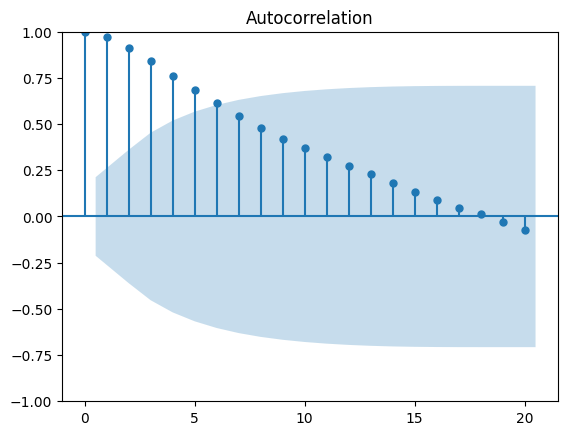

In [12]:
plot_acf(df_train['spot_price'])
plt.show()

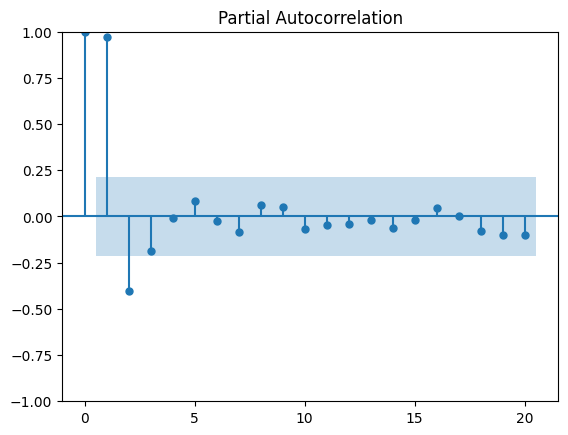

In [13]:
plot_pacf(df_train['spot_price'])
plt.show()

## "Manually" derive counts of points outside the CI in the (P)ACF

In [14]:
def manually_ish_read_autocorrelation_functions(function_a, ci_a):
    count_outside_ci = list(
        np.abs(
            function_a[1:]
        ) > (
            function_a[1:] - ci_a[1:, 0]
        )
    ).index(False)
    return count_outside_ci

In [15]:
function_acf, ci_acf = acf(df_train['spot_price'], alpha = alpha_acf_and_pacf)
function_pacf, ci_pacf = pacf(df_train['spot_price'], alpha = alpha_acf_and_pacf)

outside_of_ci_acf = manually_ish_read_autocorrelation_functions(function_acf, ci_acf)
outside_of_ci_pacf = manually_ish_read_autocorrelation_functions(function_pacf, ci_pacf)

p_heuristic_AR = outside_of_ci_pacf  # Autoregression
q_heuristic_MA = outside_of_ci_acf  # Moving average

##### Review the heuristically selected p and q values

In [16]:
p_heuristic_AR, q_heuristic_MA

(2, 6)

## Heuristically determine a good value for "d" for ARIMA model

We count the number of times we need to difference the time series to arrive at weak stationarity:

In [17]:
def difference_to_stationarity_ish(timeseries):
    ts = np.array([x for x in timeseries]) # crude?
    count_of_differencing_operations = 0
    adf_statistic, adf_p = compute_adfuller(ts)

    while adf_p > p_value_cutoff_adfuller:
        ts = ts[1:] - ts[0:-1]
        count_of_differencing_operations += 1
        adf_statistic, adf_p = compute_adfuller(ts)
        
    return count_of_differencing_operations

In [18]:
d_heuristic_ARIMA = difference_to_stationarity_ish(df_train['spot_price'])

## Report heuristically selected ARIMA order

In [19]:
(p_heuristic_AR, d_heuristic_ARIMA, q_heuristic_MA)

(2, 1, 6)

## Define a plotting function for evaluating model fit(s)

In [20]:
def plot_it_all(
    df_train,
    df_test,
    fit,
    fit_best = None,
    column_name = 'spot_price',
    label_historical = 'Historical Values',
    label_model_of_historical = 'ARIMA Fit on Historical Values',
    label_known_future = 'Known Future',
    label_forecast_future = 'Forecast Future',
):

    y_fit = fit.predict()
    y_predicted = fit.forecast(steps = len(df_test.index))

    if fit_best != None:
        y_fit_best = fit_best.predict()
    
    plt.figure()

    plt.plot(df_train.index, df_train[column_name], label = label_historical)
    plt.plot(df_train.index[2:], y_fit[2:], label = label_model_of_historical)
    plt.plot(df_test.index, df_test[column_name], label = label_known_future)
    plt.plot(df_test.index, y_predicted, label = label_forecast_future)

    if fit_best != None:
        plt.plot(df_test.index, y_fit_best[0:-1], label = 'Best auto-ARIMA')
    
    plt.xticks(rotation = 85)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

## Fit an ARIMA model using the heuristically (manually) derived order

In [21]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

model = ARIMA(
    df_train['spot_price'],
    freq = time_series_frequency,
    order = (p_heuristic_AR, d_heuristic_ARIMA, q_heuristic_MA),
)

fit = model.fit()

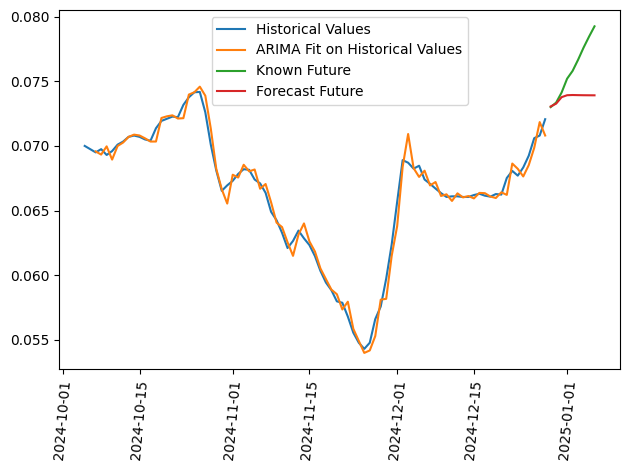

In [22]:
plot_it_all(df_train, df_test, fit)

## Perform an automated search for the best ARIMA value

In [23]:
model_best_arima = auto_arima(df_train['spot_price'], stepwise=True, trace=True)
print(model_best_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-968.168, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-921.204, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-973.563, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-961.576, Time=0.05 sec


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-923.148, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-971.999, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-971.990, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-970.429, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-975.524, Time=0.04 sec


 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-973.958, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-973.948, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-963.508, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-972.421, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.553 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   85
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 489.762
Date:                Tue, 07 Jan 2025   AIC                           -975.524
Time:                        12:43:35   BIC                           -970.662
Sample:                    10-05-2024   HQIC                          -973.570
                         - 12-28-2024                                         
Covariance Type:                  opg                                         
                 coef    st

## Report the order recommended by the automated stepwise model search

We notice that "p" and "q" are smaller for the automatically selected model when compared to those of the heuristically "manually" selected values.

Yay parsimony!

In [24]:
model_best_arima.order

(1, 1, 0)

## Forecast using "best-auto" ARIMA model

And plot the results...

Running this on 2025-01-07, we observe that the automated search for an optimal order beats my heuristically defined order, as I expected.

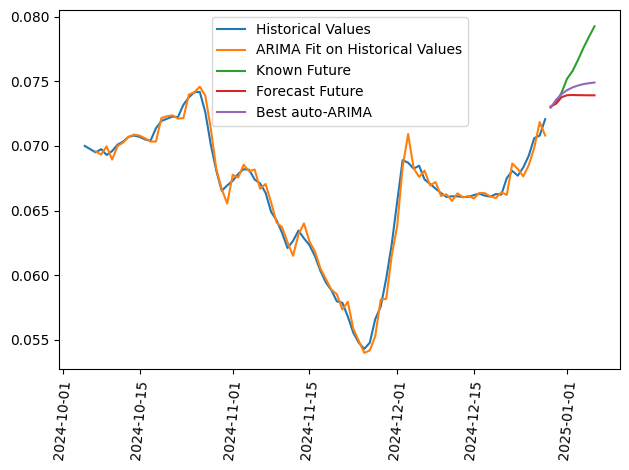

In [25]:
fit_best_arima = model_best_arima.fit(df_train)

plot_it_all(df_train, df_test, fit, fit_best = fit_best_arima)